In [71]:
import pandas as pd
import matplotlib.pyplot as plt
from math import pow

## Объявление статичных данных и списка мемоизации

In [72]:
global ki, c, T_out, u, W_mem

# коэффициент скользящего среднего (распределение важности составляющих цф)
a = 0.5

# присутствие пользователя дома. (0 - отсутсвует, 1 - присутствует)
ki = [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]

# словарь стоимостей режимов. (ключ - кол-во энергии выделяемой режимом отопления, значение - стоимость режима)
c = {0: 0, 2: 12, 4: 25, 6: 43, 8: 62, 10: 83}

# температура снаружи
T_out = [-18, -20, -20, -22, -22, -24, -24, -26, -26, -28, -28, -30]

# начальная температура
T_start = 19

# комфортная температура
T_comf = 22

# кол-во энергии выделяемой режимом отопления
u = [0, 2, 4, 6, 8, 10]

# список словарей для мемоизации. (сохранения для каждого этапа лучшего состояния)
W_mem = [{} for i in ki]



## Функция выигрыша (дискомфорт + стоимость)

In [73]:
def w(a, ki, T_cur, c):
    return ki * a * pow(T_comf - T_cur, 2) + (1 - a) * c

## Функция изменения состояния (температуры)

In [74]:
def phi(u_cur, T_cur, T_out):
    return T_cur + 0.5 * (u_cur - 0.2 * (T_cur - T_out))

## Рекурсивная функция определяющая оптимальное решения для конкретного этапа и состояния

In [75]:
def W(stage, state, a):
    # проверка была ли вычислена до этого функция для текущего этапа
    if state in W_mem[stage]:
        return W_mem[stage][state]

    w_best = None
    u_best = None
    for ui in u:
        # условный оптимальный выигрыш для последнего этапа
        if stage == 11:
            t_last = round(phi(ui, state, T_out[stage]), 1)
            wi = round(w(a, ki[stage], t_last, c[ui]), 2)

        else:
            wi = round(w(a, ki[stage], state, c[ui]) + W(stage + 1, round(phi(ui, state, T_out[stage]), 1), a)[0], 2)

        if w_best is None or wi < w_best:
            w_best = wi
            u_best = ui

    # Мемоизация
    W_mem[stage][state] = (w_best, u_best)
    return (w_best, u_best)

## Функция поиска оптимального решения для каждого этапа

In [76]:
def get_solve(a):
    # Массивы режимов работы и значений температуры на каждом этапе
    modes, temp = [], []

    # Начальная температура
    state = T_start
    
    for stage in range(len(ki)):
        temp.append(state)
        u = W(stage, state, a)[1]
        modes.append(u)
        state = round(phi(u, state, T_out[stage]), 1)
        
    return (W(0, T_start, a)[0], modes, temp, state)

## Поиск и вывод оптимального решения

In [77]:
W_best, U, T, T_last = get_solve(a)
data = [ki, U, T]
df = pd.DataFrame(data, index=['Присутств', 'Режим работы', 'Температура'], columns=[list(range(1, 13))])
df

,1,2,3,4,5,6,7,8,9,10,11,12
Присутств,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
Режим работы,10,8.0,8.0,8.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
Температура,19,20.3,20.3,20.3,20.1,18.9,15.6,11.6,7.8,4.4,1.2,-1.7


In [78]:
price = sum(map(lambda x: c[x], U))
print("Коэфициент распределения важности между дискомфортом и стоимостью:", a)
print("Значение целевой функции:", W_best)
print("Стоимость отопления:", price)
print("Температура в конце последнего этапа (после 12 часов):", T_last)

Коэфициент распределения важности между дискомфортом и стоимостью: 0.5
Значение целевой функции: 197.91
Стоимость отопления: 324
Температура в конце последнего этапа (после 12 часов): -4.5


## Анализ чувствительности:

### Посмотрим оптимальное решение при предпочтении дискомфорта.

In [79]:
a = 0.8
W_mem = [{} for i in ki]
W_best, U, T, T_last = get_solve(a)
data = [ki, U, T]
df = pd.DataFrame(data, index=['Присутств', 'Режим работы', 'Температура'], columns=[list(range(1, 13))])
df

,1,2,3,4,5,6,7,8,9,10,11,12
Присутств,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
Режим работы,10,10.0,10.0,8.0,8.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
Температура,19,20.3,21.3,22.2,21.8,21.4,19.9,15.5,11.3,7.6,4.0,0.8


In [80]:
price = sum(map(lambda x: c[x], U))
print("Коэфициент распределения важности между дискомфортом и стоимостью:", a)
print("Значение целевой функции:", W_best)
print("Стоимость отопления:", price)
print("Температура в конце последнего этапа (после 12 часов):", T_last)

Коэфициент распределения важности между дискомфортом и стоимостью: 0.8
Значение целевой функции: 96.98
Стоимость отопления: 416
Температура в конце последнего этапа (после 12 часов): -2.3


### Посмотрим оптимальное решение при предпочтении стоимости.

In [81]:
a = 0.2
W_mem = [{} for i in ki]
W_best, U, T, T_last = get_solve(a)
data = [ki, U, T]
df = pd.DataFrame(data, index=['Присутств', 'Режим работы', 'Температура'], columns=[list(range(1, 13))])
df

,1,2,3,4,5,6,7,8,9,10,11,12
Присутств,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
Режим работы,6,6.0,4.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Температура,19,18.3,17.5,15.8,14.0,11.4,7.9,4.7,1.6,-1.2,-3.9,-6.3


In [82]:
price = sum(map(lambda x: c[x], U))
print("Коэфициент распределения важности между дискомфортом и стоимостью:", a)
print("Значение целевой функции:", W_best)
print("Стоимость отопления:", price)
print("Температура в конце последнего этапа (после 12 часов):", T_last)

Коэфициент распределения важности между дискомфортом и стоимостью: 0.2
Значение целевой функции: 209.71
Стоимость отопления: 148
Температура в конце последнего этапа (после 12 часов): -8.7


### Посмотрим графики зависимости от альфа.

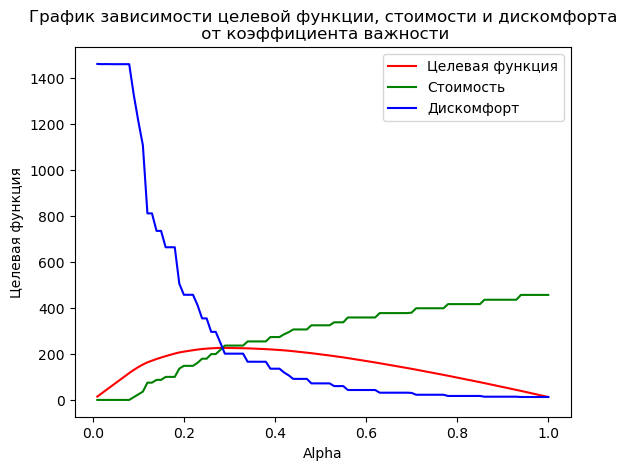

In [83]:
# Анализ чувствительности:
a_list = [i/100 for i in range(1, 101)]
W_list, c_list, dis_list = [], [], []
for i in a_list:
    a = i
    W_mem = [{} for i in ki]
    W_best, U, T, T_last = get_solve(a)
    c_cur = sum(map(lambda x: c[x], U))
    W_list.append(W_best)
    c_list.append(c_cur)
    dis_list.append((W_best - c_cur*(1-a))/a)
    
plt.plot(a_list, W_list,'r', label='Целевая функция')
plt.plot(a_list, c_list, 'g', label='Стоимость')
plt.plot(a_list, dis_list, 'b', label='Дискомфорт')
plt.title('График зависимости целевой функции, стоимости и дискомфорта\n от коэффициента важности')
plt.xlabel('Alpha')
plt.ylabel('Целевая функция')
plt.legend()
plt.show()